# Deep Learning approach: LSTM model

## Jose Antonio Jijon Vorbeck

In this notebook, we will apply the Long Short Term Memory model to perform a sentiment analysis classification to the covid-19 tweets. 

A comparisson between the results obtained here and those obtained with classical ML models will be made.

[Kaggle example](https://www.kaggle.com/anubhavsanyal/tensorflow-with-lstm-83-accuracy/notebook)

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

In [15]:
# reading the already cleaned data
train_data = pd.read_csv('Data/TweetC_train.csv')
test_data = pd.read_csv('Data/TweetC_test.csv')
print(f'Training obs: {train_data.shape[0]}, and testing obs: {test_data.shape[0]}')

Training obs: 41156, and testing obs: 3798


In [16]:
# dropping indexes with nan

# training set
index_with_nan = train_data.index[train_data.isnull().any(axis=1)]
train_data.drop(index_with_nan,0, inplace=True)

# testing set
index_with_nan = test_data.index[test_data.isnull().any(axis=1)]
test_data.drop(index_with_nan,0, inplace=True)

Splitting the training and testing data into X and y values, X -> texts, y -> labels

In [17]:
y_train = train_data.iloc[:,1]
y_test = test_data.iloc[:,1]

y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

X_train = train_data.iloc[:,0]
X_test = test_data.iloc[:,0]

Splitting the training data into training and validation datasets.

In [18]:
# 20% of the training data will be devoted to the validation dataset
train_text, validation_text, train_labels, validation_labels = train_test_split(X_train.to_numpy(), y_train.to_numpy(),test_size=0.2,random_state=0)

# making the test data into numpy formats
test_text = X_test.to_numpy()
test_labels = y_test.to_numpy()

In [19]:
print(f'The training data contains {len(train_text)} tweets, the validation contains {len(validation_text)} tweets')

The training data contains 32869 tweets, the validation contains 8218 tweets


### With the data already cleaned and devided into training, validation and testing, we can go ahead with the model

## Using Tensorflow with Keras applying an LSTM model

In [20]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Tokenization and Padding the textual data

In [21]:
tokenizer = Tokenizer(num_words=10000, oov_token='</OOV>')

In [22]:
# fitting the tokenizer on the texts
tokenizer.fit_on_texts(train_text)

# generating the sequences
train_text_sequeces = tokenizer.texts_to_sequences(train_text)

# generating the padding
train_text_padded = pad_sequences(train_text_sequeces, maxlen=35, padding = 'post') # 35 is a good number to get an average length of a tweet

# generating the sequences validation
validation_text_sequeces = tokenizer.texts_to_sequences(validation_text)

# generating the padding
validation_text_padded = pad_sequences(validation_text_sequeces, maxlen=35, padding = 'post') # 35 is a good number to get an average length of a tweet

# generating the sequences test
test_text_sequeces = tokenizer.texts_to_sequences(test_text)

# generating the padding for test
test_text_padded = pad_sequences(test_text_sequeces, maxlen=35, padding = 'post') # 35 is a good number to get an average length of a tweet


In [23]:
train_text_padded.shape # we can see that it has as many rows as tweets and as many columns as the maxlen that we set (35)

(32869, 35)

Function to plot the accuracies and loss graphs after each model trained

In [24]:
def plot_loss_acc(acc, val_acc, loss, val_loss):

    fig, axs = plt.subplots(2)
    axs[0].plot(loss)
    axs[0].plot(val_loss)
    axs[0].set_title('Training and Validation Losses')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['Train', 'Val'])
    axs[1].plot(acc)
    axs[1].plot(val_acc)
    axs[1].set_title('Training and Validation Accuracies')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(['Train', 'Val'])
    fig.tight_layout()
    plt.show()

### Now we can use keras to apply the models we want

In [25]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, GlobalAveragePooling1D, BatchNormalization, Dropout, Bidirectional
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [26]:
# model 1 

model1 = Sequential()

# instantiate an early stopping mechanism
early_stop = EarlyStopping(monitor='val_loss', patience=4)

# embedding layer
model1.add(Embedding(10000, 128, input_length=train_text_padded.shape[1]))
# pooling layer
model1.add(GlobalAveragePooling1D())
# first dense layer
model1.add(Dense(8, activation='relu'))
# output dense layer, with 5 categories, as many as our sentiments
model1.add(Dense(5, activation='softmax'))

model1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 45        
Total params: 1,281,077
Trainable params: 1,281,077
Non-trainable params: 0
_________________________________________________________________


In [27]:
# compiling the model and fitting it 
model1.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])
history_1 = model1.fit(train_text_padded, train_labels, epochs = 20, validation_data=(validation_text_padded, validation_labels), callbacks=[early_stop])

Epoch 1/20
1028/1028 [==============================] - 21s 20ms/step - loss: 1.4611 - accuracy: 0.3526 - val_loss: 1.0328 - val_accuracy: 0.6090
Epoch 2/20
1028/1028 [==============================] - 19s 19ms/step - loss: 0.8925 - accuracy: 0.6782 - val_loss: 0.8850 - val_accuracy: 0.6817
Epoch 3/20
1028/1028 [==============================] - 22s 22ms/step - loss: 0.6911 - accuracy: 0.7782 - val_loss: 0.8726 - val_accuracy: 0.6932
Epoch 4/20
1028/1028 [==============================] - 22s 21ms/step - loss: 0.5913 - accuracy: 0.8189 - val_loss: 0.8844 - val_accuracy: 0.6986
Epoch 5/20
1028/1028 [==============================] - 19s 19ms/step - loss: 0.5167 - accuracy: 0.8456 - val_loss: 0.9460 - val_accuracy: 0.6862
Epoch 6/20
1028/1028 [==============================] - 21s 20ms/step - loss: 0.4533 - accuracy: 0.8657 - val_loss: 0.9533 - val_accuracy: 0.6948
Epoch 7/20
1028/1028 [==============================] - 23s 23ms/step - loss: 0.4062 - accuracy: 0.8833 - val_loss: 1.0088 -

In [28]:
model1.evaluate(validation_text_padded, validation_labels)

257/257 [==============================] - 1s 3ms/step - loss: 1.0088 - accuracy: 0.6852


[1.0087827444076538, 0.6852031946182251]

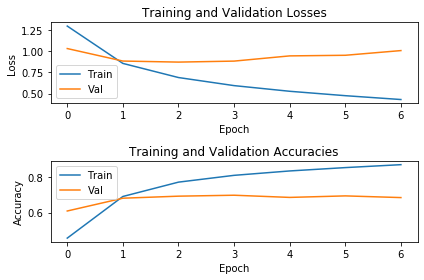

In [29]:
plot_loss_acc(history_1.history['accuracy'], history_1.history['val_accuracy'], history_1.history['loss'], history_1.history['val_loss'])

### Model 2

adding dropout

In [30]:
model2 = Sequential()


# instantiate an early stopping mechanism
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# embedding layer
model2.add(Embedding(10000, 128, input_length=train_text_padded.shape[1]))
# pooling layer
model2.add(GlobalAveragePooling1D())
# first dense layer
model2.add(Dense(16, activation='relu'))
# dropout 
model2.add(Dropout(0.4))
# second hidden layer
model2.add(Dense(8, activation='relu'))
# output dense layer, with 5 categories, as many as our sentiments
model2.add(Dense(5, activation='softmax'))

model2.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 35, 128)           1280000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 45        
Total params: 1,282,245
Trainable params: 1,282,245
Non-trainable params: 0
____________________________________________

In [31]:
# compiling the model and fitting it 
model2.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])
history_2 = model2.fit(train_text_padded, train_labels, epochs = 25, validation_data=(validation_text_padded, validation_labels), callbacks=[early_stop])

Epoch 1/25
1028/1028 [==============================] - 24s 23ms/step - loss: 1.4812 - accuracy: 0.3232 - val_loss: 1.0412 - val_accuracy: 0.6021
Epoch 2/25
1028/1028 [==============================] - 20s 20ms/step - loss: 0.9768 - accuracy: 0.6045 - val_loss: 0.8717 - val_accuracy: 0.6927
Epoch 3/25
1028/1028 [==============================] - 20s 20ms/step - loss: 0.8054 - accuracy: 0.6968 - val_loss: 0.8252 - val_accuracy: 0.7048
Epoch 4/25
1028/1028 [==============================] - 20s 19ms/step - loss: 0.7152 - accuracy: 0.7388 - val_loss: 0.8352 - val_accuracy: 0.6987
Epoch 5/25
1028/1028 [==============================] - 22s 21ms/step - loss: 0.6465 - accuracy: 0.7704 - val_loss: 0.8325 - val_accuracy: 0.7110
Epoch 6/25
1028/1028 [==============================] - 20s 19ms/step - loss: 0.5993 - accuracy: 0.7809 - val_loss: 0.8670 - val_accuracy: 0.6985


In [32]:
model2.evaluate(validation_text_padded, validation_labels)

257/257 [==============================] - 1s 2ms/step - loss: 0.8670 - accuracy: 0.6985


[0.8669770956039429, 0.6984667778015137]

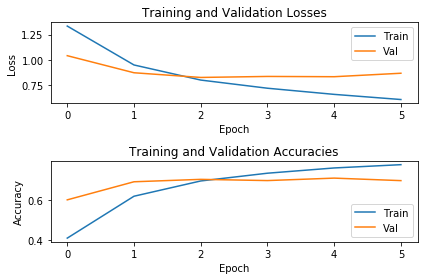

In [33]:
plot_loss_acc(history_2.history['accuracy'], history_2.history['val_accuracy'], history_2.history['loss'], history_2.history['val_loss'])

### Model 3 

Now we will apply LSTM layer to the model

In [34]:
model3 = Sequential()


# instantiate an early stopping mechanism
early_stop = EarlyStopping(monitor='val_loss', patience=1)

# embedding layer
model3.add(Embedding(10000, 128, input_length=train_text_padded.shape[1]))
# LSTM layer
model3.add(LSTM(8))
# second hidden layer
model3.add(Dense(8, activation='relu'))
# output dense layer, with 5 categories, as many as our sentiments
model3.add(Dense(5, activation='softmax'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 35, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 4384      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 45        
Total params: 1,284,501
Trainable params: 1,284,501
Non-trainable params: 0
_________________________________________________________________


In [35]:
# compiling the model and fitting it 
model3.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])
history_3 = model3.fit(train_text_padded, train_labels, epochs = 7, validation_data=(validation_text_padded, validation_labels), callbacks=[early_stop])

Epoch 1/7
1028/1028 [==============================] - 42s 39ms/step - loss: 1.5052 - accuracy: 0.3125 - val_loss: 1.0601 - val_accuracy: 0.5807
Epoch 2/7
1028/1028 [==============================] - 37s 36ms/step - loss: 0.8634 - accuracy: 0.6760 - val_loss: 0.8304 - val_accuracy: 0.6931
Epoch 3/7
1028/1028 [==============================] - 36s 35ms/step - loss: 0.5773 - accuracy: 0.8158 - val_loss: 0.8131 - val_accuracy: 0.7162
Epoch 4/7
1028/1028 [==============================] - 36s 35ms/step - loss: 0.4534 - accuracy: 0.8601 - val_loss: 0.8441 - val_accuracy: 0.7070


In [36]:
model3.evaluate(validation_text_padded, validation_labels)

257/257 [==============================] - 1s 6ms/step - loss: 0.8441 - accuracy: 0.7070


[0.8440619111061096, 0.7069846391677856]

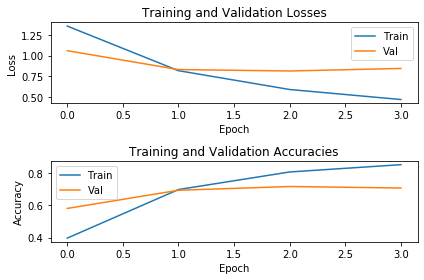

In [37]:
plot_loss_acc(history_3.history['accuracy'], history_3.history['val_accuracy'], history_3.history['loss'], history_3.history['val_loss'])

### Model 4 

Enhancing the performance of the LSTM model by applying dropout and another Dense layer

In [38]:
model4 = Sequential()


# instantiate an early stopping mechanism
early_stop = EarlyStopping(monitor='val_loss', patience=2)

# saving the best model
saveBestModel = ModelCheckpoint('best_model.hdf5', monitor='val_acc', save_best_only=True, save_weights_only=False)

# embedding layer
model4.add(Embedding(10000, 128, input_length=train_text_padded.shape[1]))
# LSTM layer
model4.add(Bidirectional(LSTM(128)))
# second hidden layer
model4.add(Dense(128, activation='relu'))
# dropout 
model4.add(Dropout(0.4))
# third layer 
model4.add(Dense(64, activation = 'relu'))
# dropout 
model4.add(Dropout(0.4))
# fourth layer 
model4.add(Dense(32, activation = 'relu'))
# output dense layer, with 5 categories, as many as our sentiments
model4.add(Dense(5, activation='softmax'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 35, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)               

In [39]:
# compiling the model and fitting it 
model4.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])
history_4 = model4.fit(train_text_padded, train_labels, epochs = 10, validation_data=(validation_text_padded, validation_labels), callbacks=[early_stop, saveBestModel])

Epoch 1/10
1028/1028 [==============================] - 128s 117ms/step - loss: 1.2991 - accuracy: 0.4332 - val_loss: 0.8363 - val_accuracy: 0.6884
Epoch 2/10
1028/1028 [==============================] - 89s 87ms/step - loss: 0.7030 - accuracy: 0.7514 - val_loss: 0.7347 - val_accuracy: 0.7367
Epoch 3/10
1028/1028 [==============================] - 126s 122ms/step - loss: 0.5496 - accuracy: 0.8152 - val_loss: 0.7341 - val_accuracy: 0.7454
Epoch 4/10
1028/1028 [==============================] - 122s 119ms/step - loss: 0.4455 - accuracy: 0.8537 - val_loss: 0.8337 - val_accuracy: 0.7327
Epoch 5/10
1028/1028 [==============================] - 119s 116ms/step - loss: 0.3584 - accuracy: 0.8832 - val_loss: 0.8929 - val_accuracy: 0.7279


In [40]:
model4.evaluate(validation_text_padded, validation_labels)

257/257 [==============================] - 8s 30ms/step - loss: 0.8929 - accuracy: 0.7279


[0.892868161201477, 0.7279143333435059]

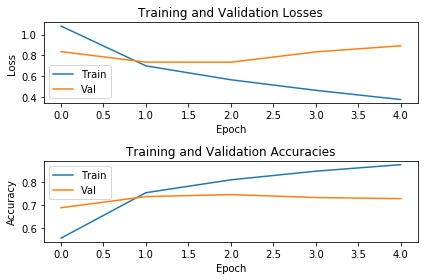

In [41]:
plot_loss_acc(history_4.history['accuracy'], history_4.history['val_accuracy'], history_4.history['loss'], history_4.history['val_loss'])

### Evaluating the model with the test dataset

making the evaluation, and obtaining the precission, recall, accuracy and f-1 scores from it

In [42]:
model4.metrics_names

['loss', 'accuracy']

## Evaluation of the results of the final model

In [43]:
test_pred = model4.predict(test_text_padded)
test_pred = test_pred.round().astype(int)

In [44]:
labels = {'Extremely Negative': 0,
          'Extremely Positive': 1,
          'Negative': 2,
          'Neutral': 3,
          'Positive': 4}

In [45]:
# transforming the pred vectors to its label:
test_pred_cat = np.zeros(test_pred.shape[0],)
test_labels_cat = np.zeros(test_pred.shape[0],)
for i in range(0,test_pred.shape[0],1):
  test_pred_cat[i] = test_pred[i].argmax()
  test_labels_cat[i] = test_labels[i].argmax()

test_pred_cat = test_pred_cat.astype(int)
test_labels_cat = test_labels_cat.astype(int)

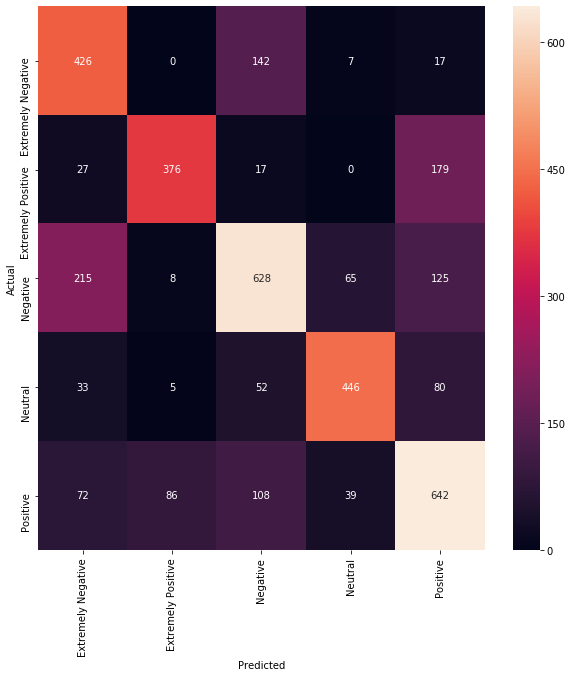

In [48]:
conf_mat = confusion_matrix(test_labels_cat, test_pred_cat)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels.keys(), yticklabels=labels.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [49]:
print(classification_report(test_labels_cat, test_pred_cat, target_names= labels.keys()))

                    precision    recall  f1-score   support

Extremely Negative       0.55      0.72      0.62       592
Extremely Positive       0.79      0.63      0.70       599
          Negative       0.66      0.60      0.63      1041
           Neutral       0.80      0.72      0.76       616
          Positive       0.62      0.68      0.65       947

          accuracy                           0.66      3795
         macro avg       0.68      0.67      0.67      3795
      weighted avg       0.68      0.66      0.67      3795

